In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


**Load Datasets**

In [22]:
pi_items = pd.read_csv("data/PI_ITEM_LIST.csv")
gi_items = pd.read_csv("data/GI_ITEM_LIST.csv")
waste    = pd.read_csv("data/Inventory_Waste_CompanyData.csv")

print("PI shape:", pi_items.shape)
print("GI shape:", gi_items.shape)
print("Waste shape:", waste.shape)


PI shape: (1500, 8)
GI shape: (1500, 9)
Waste shape: (2000, 7)


**Exploratory Data Analysis (EDA)**

In [23]:
print("=== PI Items ===")
display(pi_items.head())
print()
print("=== GI Items ===")
display(gi_items.head())
print()
print("=== Waste Data ===")
display(waste.head())


=== PI Items ===


,SI.,Product Name,Item Code,UOM,Purchase UOM,Product Category,Origin Rule,Purchase Cost
0,1,ALUMINIUM U. FLANGE 20MM,PI-ALU-UFL-20,MTR,Length (5 MTR),Accessory,NaN,1.75
1,2,ALUMINIUM JOINT. FLANGE 20MM (KS),PI-ALU-JFL-20KS,MTR,Length (5 MTR),Accessory,NaN,2.50
2,3,ALUMINIUM JOINT. FLANGE 20MM,PI-ALU-JFL-20,MTR,Length (5 MTR),Accessory,NaN,2.75
3,4,ALUMINIUM U FLANGE 20MM (KS),PI-ALU-UFL-20KS,MTR,Length (5 MTR),Accessory,NaN,1.80
4,5,ALUMINIUM CH. FLANGE 20MM (KS),PI-ALU-CHFL-20KS,MTR,Length (5 MTR),Accessory,NaN,2.20



=== GI Items ===


,SI.,Product Name,Item Code,UOM,Purchase UOM,Product Category,Origin Rule,Unit Cost,Unnamed: 8
0,1,20MM FLANGES,FL-20MM,MTR,Length (5 MTR),Accessory,NaN,1.39,NaN
1,2,30MM FLANGES,FL-30MM,MTR,Length (5 MTR),Accessory,NaN,2.24,NaN
2,3,40MM FLANGES,FL-40MM,MTR,Length (5 MTR),Accessory,NaN,3.79,NaN
3,4,20MM CORNER,CR-20MM,NOS,BOX (200 NOS),Accessory,NaN,0.28,NaN
4,5,30MM CORNER,CR-30MM,NOS,BOX (200 NOS),Accessory,NaN,0.24,NaN



=== Waste Data ===


,Job ID,Material Type,Area (sq/m),Thickness (mm),Material Cost (AED),Waste Percentage,Waste Cost (AED)
0,JOB_1,PI,68.64,20.0,2186.09,0.1750,382.57
1,JOB_2,GI,58.88,0.7,1017.49,0.0244,24.83
2,JOB_3,GI,35.81,0.7,630.32,0.0725,45.70
3,JOB_4,GI,14.00,1.1,380.97,0.1782,67.89
4,JOB_5,PI,15.80,25.0,634.38,0.1898,120.41


In [24]:
waste.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Job ID               2000 non-null   object 
 1   Material Type        2000 non-null   object 
 2   Area (sq/m)          2000 non-null   float64
 3   Thickness (mm)       2000 non-null   float64
 4   Material Cost (AED)  2000 non-null   float64
 5   Waste Percentage     2000 non-null   float64
 6   Waste Cost (AED)     2000 non-null   float64
dtypes: float64(5), object(2)
memory usage: 109.5+ KB


In [25]:
waste.describe()


,Area (sq/m),Thickness (mm),Material Cost (AED),Waste Percentage,Waste Cost (AED)
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,37.219965,12.261790,1103.367375,0.104004,128.418600
std,17.249838,11.819856,670.286873,0.053071,119.655718
min,6.020000,0.550000,82.810000,0.020000,3.020000
25%,22.050000,0.800000,577.375000,0.059175,38.767500
50%,37.275000,1.200000,975.775000,0.102000,86.525000
75%,51.410000,25.000000,1506.210000,0.144000,189.425000
max,69.960000,30.000000,3600.330000,0.219900,765.990000


**Clean & Standardize Column Names**

In [26]:
def clean_cols(df):
    df.columns = (
        df.columns.str.strip()
        .str.replace(" ", "_")
        .str.replace("(", "", regex=False)
        .str.replace(")", "", regex=False)
        .str.replace(".", "", regex=False)
    )
    return df

pi_items = clean_cols(pi_items)
gi_items = clean_cols(gi_items)
waste    = clean_cols(waste)


**Prepare Material Master Table**

In [27]:
# Label each item list
pi_items["Material_Type"] = "PI"
gi_items["Material_Type"] = "GI"

# Standardize cost column name
pi_items = pi_items.rename(columns={"Purchase_Cost": "Unit_Cost"})

# Average cost per material type
pi_summary = pi_items.groupby("Material_Type")["Unit_Cost"].mean().reset_index()
gi_summary = gi_items.groupby("Material_Type")["Unit_Cost"].mean().reset_index()

material_summary = pd.concat([pi_summary, gi_summary], ignore_index=True)
print(material_summary)


  Material_Type  Unit_Cost
0            PI  23.966233
1            GI  14.094270


**Merge Material Master with Waste Data**

In [28]:
waste_merged = waste.merge(material_summary, on="Material_Type", how="left")
print("Merged shape:", waste_merged.shape)
waste_merged.head()


Merged shape: (2000, 8)


,Job_ID,Material_Type,Area_sq/m,Thickness_mm,Material_Cost_AED,Waste_Percentage,Waste_Cost_AED,Unit_Cost
0,JOB_1,PI,68.64,20.0,2186.09,0.1750,382.57,23.966233
1,JOB_2,GI,58.88,0.7,1017.49,0.0244,24.83,14.094270
2,JOB_3,GI,35.81,0.7,630.32,0.0725,45.70,14.094270
3,JOB_4,GI,14.00,1.1,380.97,0.1782,67.89,14.094270
4,JOB_5,PI,15.80,25.0,634.38,0.1898,120.41,23.966233


**Feature Engineering**

In [29]:
waste_merged["Cost_per_sqm"] = waste_merged["Material_Cost_AED"] / waste_merged["Area_sq/m"]

model_df = waste_merged[
    ["Material_Type", "Area_sq/m", "Thickness_mm", "Material_Cost_AED",
     "Waste_Percentage", "Unit_Cost", "Cost_per_sqm", "Waste_Cost_AED"]
].dropna()

print("Model dataframe shape:", model_df.shape)
model_df.head()


Model dataframe shape: (2000, 8)


,Material_Type,Area_sq/m,Thickness_mm,Material_Cost_AED,Waste_Percentage,Unit_Cost,Cost_per_sqm,Waste_Cost_AED
0,PI,68.64,20.0,2186.09,0.1750,23.966233,31.848631,382.57
1,GI,58.88,0.7,1017.49,0.0244,14.094270,17.280740,24.83
2,GI,35.81,0.7,630.32,0.0725,14.094270,17.601787,45.70
3,GI,14.00,1.1,380.97,0.1782,14.094270,27.212143,67.89
4,PI,15.80,25.0,634.38,0.1898,23.966233,40.150633,120.41


**Correlation Heatmap (Numeric Features)**

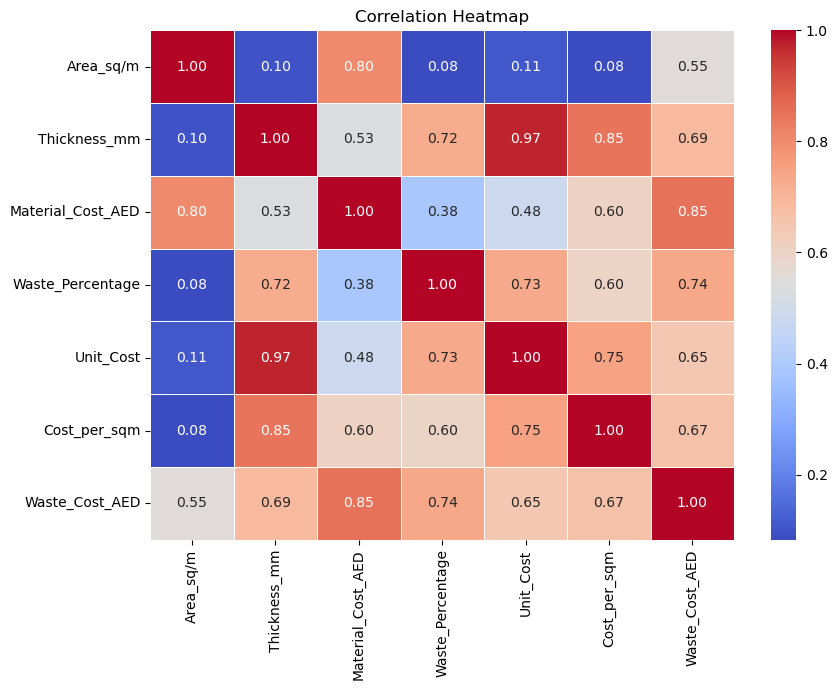

In [30]:
plt.figure(figsize=(9, 7))
sns.heatmap(model_df.select_dtypes(include=np.number).corr(),
            annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


**Define Features (X) and Target (y)**

In [31]:
X = model_df.drop(columns=["Waste_Percentage"])
y = model_df["Waste_Percentage"]

print("Features:", list(X.columns))
print("Target: Waste_Percentage")
print(f"X shape: {X.shape}, y shape: {y.shape}")


Features: ['Material_Type', 'Area_sq/m', 'Thickness_mm', 'Material_Cost_AED', 'Unit_Cost', 'Cost_per_sqm', 'Waste_Cost_AED']
Target: Waste_Percentage
X shape: (2000, 7), y shape: (2000,)


**Train / Test Split**

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set:     {X_test.shape[0]} samples")


Training set: 1600 samples
Test set:     400 samples


**Build & Train Random Forest Pipeline**

In [33]:
categorical = ["Material_Type"]
numeric = [col for col in X.columns if col not in categorical]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical),
        ("num", "passthrough", numeric)
    ]
)

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rf", RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Material_Type']),
                                                 ('num', 'passthrough',
                                                  ['Area_sq/m', 'Thickness_mm',
                                                   'Material_Cost_AED',
                                                   'Unit_Cost', 'Cost_per_sqm',
                                                   'Waste_Cost_AED'])])),
                ('rf',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

**Model Evaluation**

In [34]:
y_train_pred = rf_pipeline.predict(X_train)
y_test_pred  = rf_pipeline.predict(X_test)

print("=== Training Set ===")
print(f"  RMSE : {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
print(f"  MAE  : {mean_absolute_error(y_train, y_train_pred):.4f}")
print(f"  R²   : {r2_score(y_train, y_train_pred):.4f}")

print()
print("=== Test Set ===")
print(f"  RMSE : {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")
print(f"  MAE  : {mean_absolute_error(y_test, y_test_pred):.4f}")
print(f"  R²   : {r2_score(y_test, y_test_pred):.4f}")


=== Training Set ===
  RMSE : 0.0021
  MAE  : 0.0013
  R²   : 0.9985

=== Test Set ===
  RMSE : 0.0047
  MAE  : 0.0030
  R²   : 0.9919


**Visualizations**

**1. Actual vs Predicted (Test Set)**

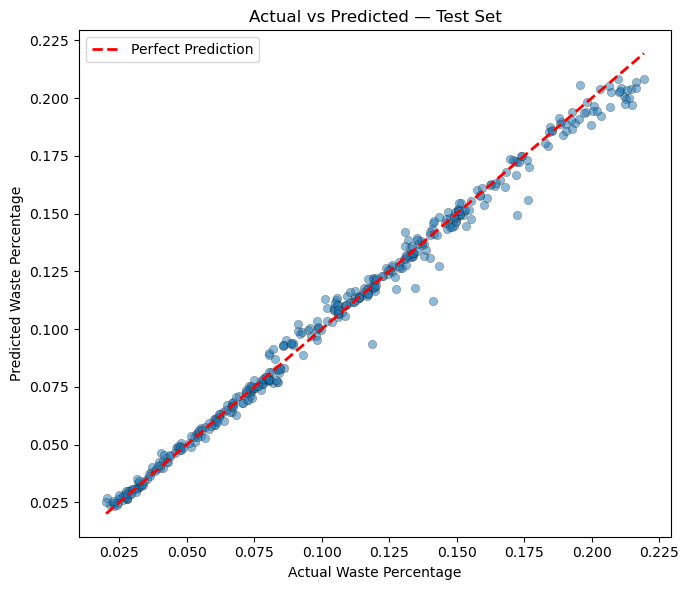

In [35]:
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, edgecolors="k", linewidths=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         "r--", lw=2, label="Perfect Prediction")
plt.xlabel("Actual Waste Percentage")
plt.ylabel("Predicted Waste Percentage")
plt.title("Actual vs Predicted — Test Set")
plt.legend()
plt.tight_layout()
plt.show()


**2. Residual Plot (Test Set)**

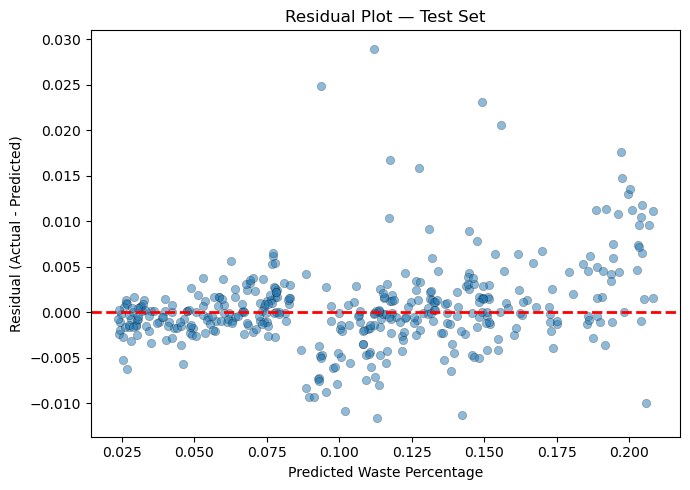

In [36]:
residuals = y_test - y_test_pred

plt.figure(figsize=(7, 5))
plt.scatter(y_test_pred, residuals, alpha=0.5, edgecolors="k", linewidths=0.3)
plt.axhline(0, color="red", linestyle="--", lw=2)
plt.xlabel("Predicted Waste Percentage")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot — Test Set")
plt.tight_layout()
plt.show()


**3. Feature Importance**

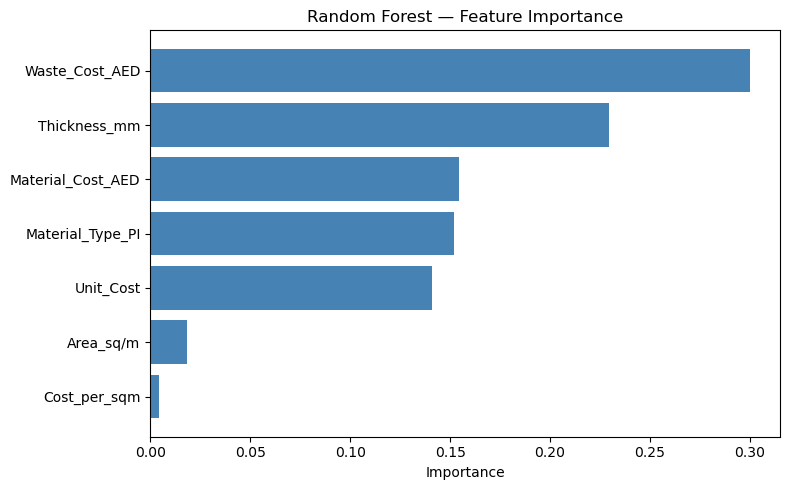

In [37]:
encoded_cat = list(
    rf_pipeline.named_steps["preprocessor"]
    .named_transformers_["cat"]
    .get_feature_names_out(["Material_Type"])
)

all_features = encoded_cat + numeric
importances  = rf_pipeline.named_steps["rf"].feature_importances_

fi = pd.DataFrame({"Feature": all_features, "Importance": importances})
fi = fi.sort_values("Importance", ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(fi["Feature"], fi["Importance"], color="steelblue")
plt.xlabel("Importance")
plt.title("Random Forest — Feature Importance")
plt.tight_layout()
plt.show()


**4. Average Waste Percentage by Material Type**

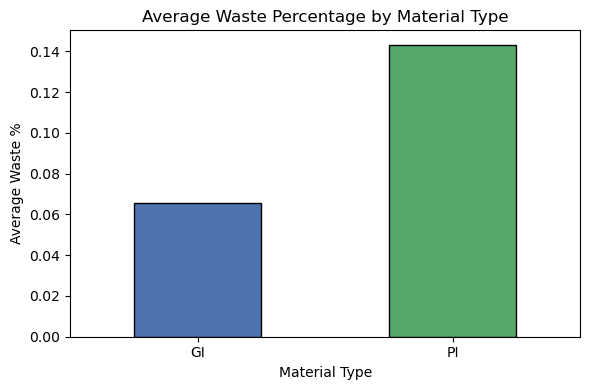

In [38]:
mean_waste = waste_merged.groupby("Material_Type")["Waste_Percentage"].mean()

plt.figure(figsize=(6, 4))
mean_waste.plot(kind="bar", color=["#4c72b0", "#55a868"], edgecolor="black")
plt.title("Average Waste Percentage by Material Type")
plt.xlabel("Material Type")
plt.ylabel("Average Waste %")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


**5. Area vs Waste Cost**

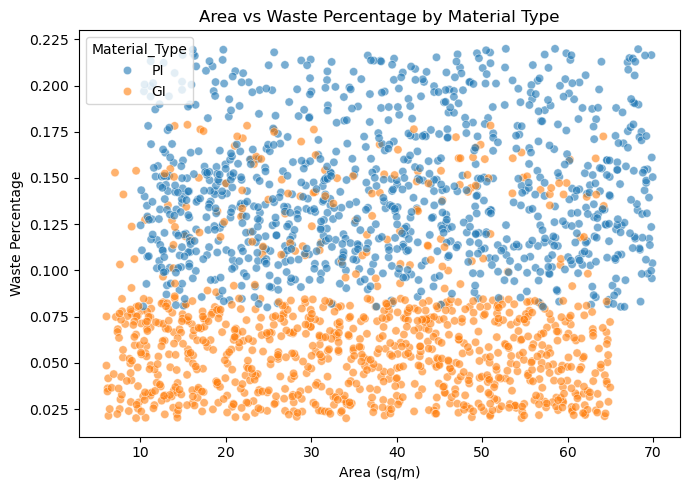

In [39]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=waste_merged, x="Area_sq/m", y="Waste_Percentage",
                hue="Material_Type", alpha=0.6)
plt.title("Area vs Waste Percentage by Material Type")
plt.xlabel("Area (sq/m)")
plt.ylabel("Waste Percentage")
plt.tight_layout()
plt.show()


**6. Distribution of Waste Cost**

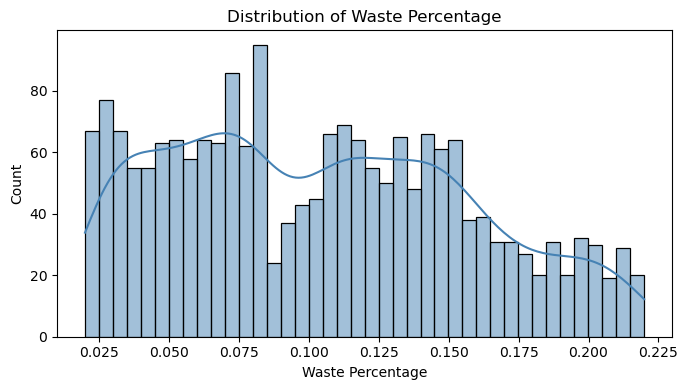

In [40]:
plt.figure(figsize=(7, 4))
sns.histplot(waste_merged["Waste_Percentage"], kde=True, bins=40, color="steelblue")
plt.title("Distribution of Waste Percentage")
plt.xlabel("Waste Percentage")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
